In [1]:
# A notebook to attempt to rehabilitate distances as meaningful features:
import pybiomart
import os
import pickle
import pandas as pd
import seaborn as sns
import pybedtools
import pybedtools.featurefuncs as featurefuncs
import umap
import numpy as np
from sklearn.preprocessing import maxabs_scale

In [2]:
activity_var_df = pd.read_pickle("data/activity_features.pkl")
ctcf_var_df = pd.read_pickle("data/iap_variances.pkl")
tissue_var_df = pd.read_pickle("data/activity_tissue_variances.pkl")

concat_list = [activity_var_df.sort_index(),
               ctcf_var_df.iloc[:, 7:].sort_index(),
               tissue_var_df.iloc[:, 7:].sort_index()]
total_df = pd.concat(concat_list, axis=1)
total_df.shape

(8059, 67)

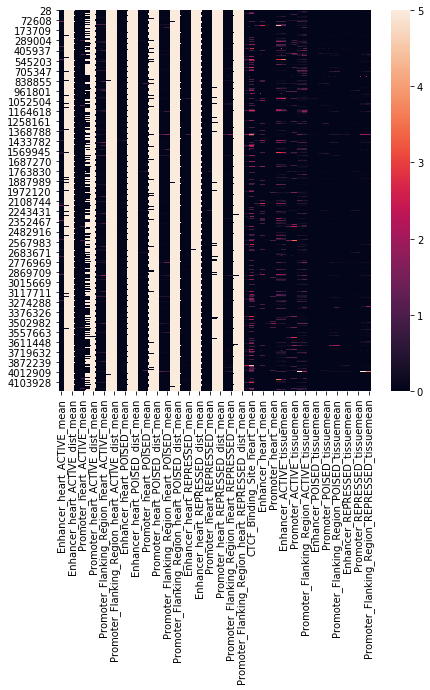

In [3]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [7, 7]

sns.heatmap(total_df.iloc[:, 8:], vmax=5)

In [4]:
total_df["integer_encodings"] = total_df["val_result"].copy()
total_df["val_result"] = total_df["val_result"].replace("-1", "Untested")
print(total_df.shape)

total_df.loc[:, "integer_encodings"] = \
    total_df.loc[:, "integer_encodings"].replace("Untested", -1)
total_df.loc[:, "integer_encodings"] = \
    total_df.loc[:, "integer_encodings"].replace("True ME", 1)
total_df.loc[:, "integer_encodings"] = \
    total_df.loc[:, "integer_encodings"].replace("False-positive", 2)
total_df.loc[:, "integer_encodings"] = \
    total_df.loc[:, "integer_encodings"].replace("Tissue-specific", 3)
total_df.loc[:, "integer_encodings"] = \
    total_df.loc[:, "integer_encodings"].replace(3, 1)
print(total_df.shape)

cols = []
cols = total_df.columns.tolist()
cols = cols[:7] + [cols[-1]] + cols[7:-1]
total_df = total_df.loc[:, cols]
print(total_df.shape)

# Generating validation dataframe for model training:
val_df = total_df[total_df.val_result != "Untested"].copy()
val_df.loc[:, "integer_encodings"] = \
    val_df.loc[:, "integer_encodings"].replace(3, 2)

(8059, 68)
(8059, 68)
(8059, 68)


In [28]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.preprocessing import MaxAbsScaler, scale

# Normalising variances & counts:
transformer = MaxAbsScaler().fit(total_df.iloc[:, 8:])
total_abs = transformer.transform(total_df.iloc[:, 8:])
val_abs = transformer.transform(val_df.iloc[:, 8:])

# Using mutualinfo to extract relevant features:
def mi_kbest_selector(data, labels, k=60):
    selector = SelectKBest(mutual_info_classif, k)
    selector.fit(data, labels)
    return data[:, selector.get_support(indices=True)], selector.get_support(indices=True)

k_best_df, support = mi_kbest_selector(val_abs, val_df["integer_encodings"])

# Extracting high variance features:
kbest_total = total_abs[:, support]
kbest_val = val_abs[:, support]

In [29]:
kbest_total.shape

(8059, 60)

In [30]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(kbest_total)
total_category_labels = pd.Series(kmeans.labels_)
total_category_labels.index = total_df["element_id"].astype(int).to_list()

sorted_total_df = total_df.iloc[:, 0:7].copy(deep=True)
sorted_total_df["cluster_assignments"] = total_category_labels
sorted_total_df = sorted_total_df.sort_values(by=["cluster_assignments"])
hue_order = ["A", "B", "C", "D", "E"]

In [31]:
kbest_total = pd.DataFrame(kbest_total)
kbest_total.index = total_df["element_id"].astype(int).to_list()

In [32]:
matplotlib.rcParams['figure.figsize'] = [40, 10]
kbest_total["cluster_assignments"] = sorted_total_df["cluster_assignments"]

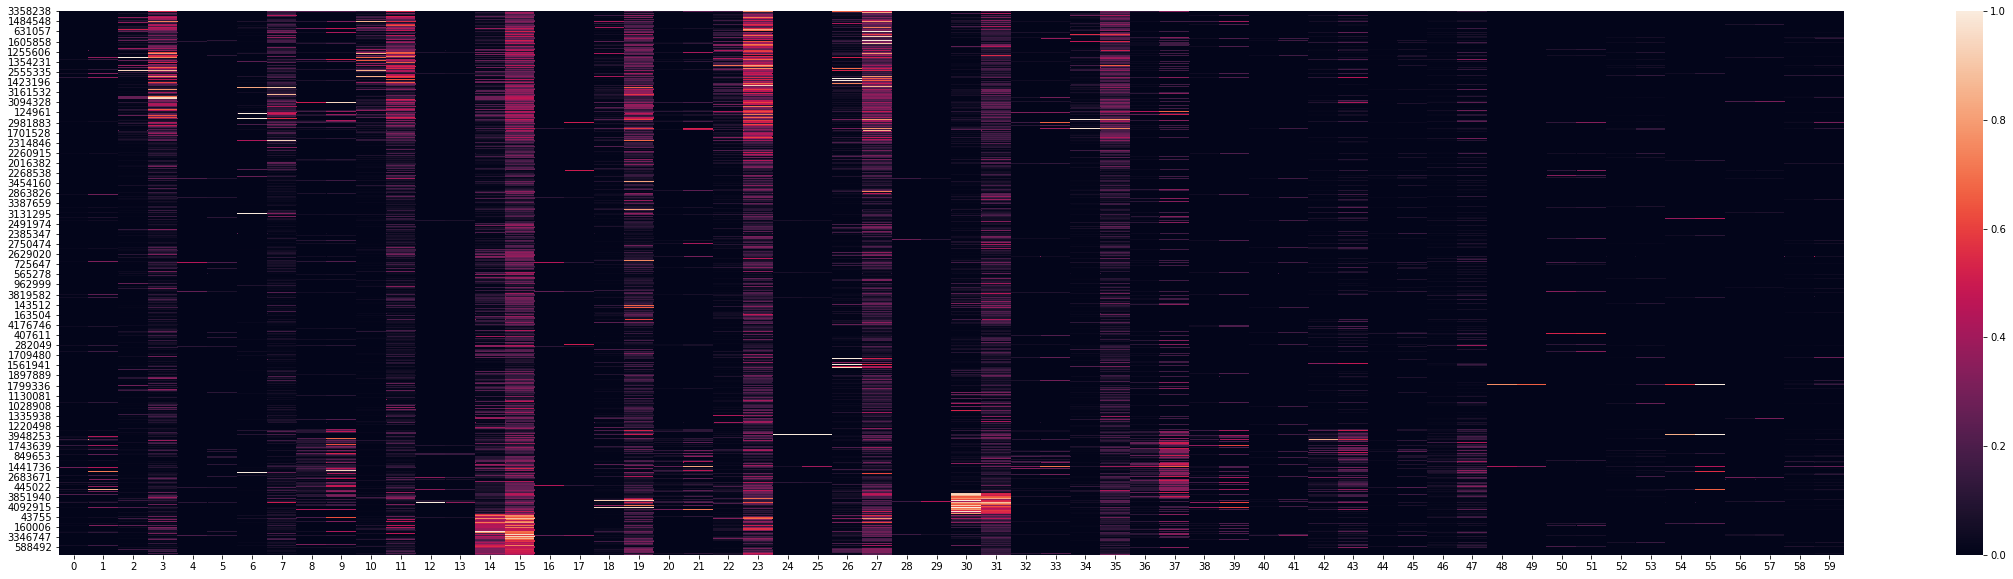

In [33]:
kbest_total = kbest_total.sort_values(by=["cluster_assignments"])
ax = sns.heatmap(kbest_total.iloc[:, :-1], vmin=0)

In [34]:
pyroval_bed = pybedtools.BedTool("data/IAP_validation.July2019.stranded.with_IDs.bed")
names = ["chrom", "start", "end", "strand", "gene",
         "blueprint", "ear", "b_cell", "val_status", "element_id"]
pyroval_df = pyroval_bed.to_dataframe(names=names)
pyroval_df = pyroval_df[pyroval_df["ear"].notnull()]
pyroval_df = pyroval_df[pyroval_df["element_id"] != "."]
pyroval_df = pyroval_df[pyroval_df["chrom"] != "chrX"]

pyroval_df.index = pyroval_df["element_id"].astype(int).to_list()
pyroval_df

,chrom,start,end,strand,gene,blueprint,ear,b_cell,val_status,element_id
353879,chr10,18139121,18139597,+,Ect2l,28.479482,12.356460,NaN,True ME,353879
363443,chr10,23726341,23726813,+,Rps12,52.083333,12.379583,NaN,True ME,363443
420013,chr10,59381799,59387060,+,P4ha1,29.895833,12.489792,NaN,True ME,420013
457485,chr10,78020226,78025621,+,Aire,30.208333,12.930833,NaN,True ME,457485
499010,chr10,99599559,99600037,+,Gm20110,29.166667,19.832917,NaN,True ME,499010
...,...,...,...,...,...,...,...,...,...,...
3906187,chr8,72024783,72033082,-,Cyp4f18,41.020833,4.624444,7.175556,False-positive,3906187
3906764,chr8,72228229,72232950,-,Fam32a,30.104167,0.551666,5.849000,False-positive,3906764
4200422,chr9,103108602,103109112,+,Rab6b,37.500000,44.126670,NaN,True ME,4200422
4245666,chr9,123742717,123749810,-,Ccr9,36.875000,1.207500,12.340000,Tissue-specific,4245666


In [35]:
sorted_total_df["ear"] = pyroval_df["ear"]
blueprint_categories = sorted_total_df[sorted_total_df.ear.notnull()]
blueprint_categories["cluster_assignments"].value_counts(sort=False).sort_index()

0    11
1    17
2    58
3     1
4     6
Name: cluster_assignments, dtype: int64

Text(0, 0.5, 'Range of methylation across individuals (%)')

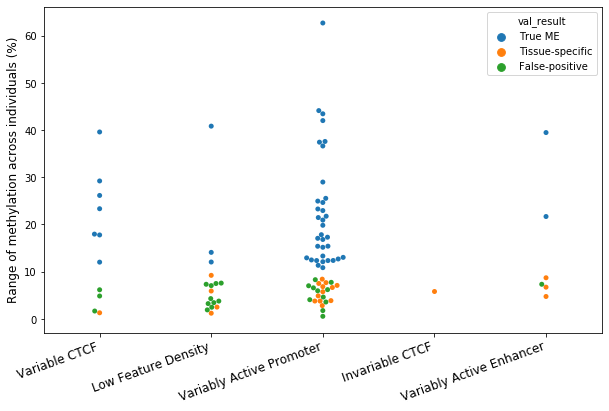

In [36]:
matplotlib.rcParams['figure.figsize'] = [10, 6]
ax = sns.swarmplot(x="cluster_assignments", y="ear", hue="val_result", data=blueprint_categories)
ax.set(xticklabels=["Variable CTCF", "Low Feature Density",
                    "Variably Active Promoter", "Invariable CTCF",
                    "Variably Active Enhancer"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, fontsize=12, horizontalalignment='right')
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("Range of methylation across individuals (%)", fontsize=12)

In [ ]:
from yellowbrick.cluster.elbow import kelbow_visualizer
matplotlib.rcParams['figure.figsize'] = [15, 10]

kelbow_visualizer(KMeans(random_state=0), kbest_total_abs, k=(2,15))